In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# pix2pix: Image-to-image translation with a conditional GAN

## Import TensorFlow and other libraries

In [2]:
import tensorflow as tf
#print(tf.__version__)
import os
import pathlib
import time
import datetime
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

In [3]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [158]:
#dataset_name = "adc2ncct"
#dataset_name = "ncct2adc"
#dataset_name = "adc2dwi"
#dataset_name = "dwi2adc"
#dataset_name = "ncct2dwi"
#dataset_name = "dwi2ncct"

#dataset_name = "ncct2adc-noss"
#dataset_name = "adc2ncct-noss"
#dataset_name = "adc2dwi-noss"
#dataset_name = "dwi2adc-noss"
#dataset_name = "ncct2dwi-noss"
dataset_name = "dwi2ncct-noss"

In [159]:
#_URL = f'file:///data/Datasets/stroke/ggarzon/foscal_jpg/{dataset_name}.tar.xz'
_URL = f'file:///home/gustavogarzon/code/pix2pix/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.xz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

13492224/13477453 [==============================] - 1s 0us/step


In [160]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/dwi2ncct-noss'),
 PosixPath('/root/.keras/datasets/logs'),
 PosixPath('/root/.keras/datasets/dwi2ncct-noss.tar.xz'),
 PosixPath('/root/.keras/datasets/model.png')]

In [156]:
!rm -rf /root/.keras/datasets/dwi*

## Load the dataset

Download the CMP Facade Database data (30MB). Additional datasets are available in the same format [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external}. In Colab you can select other datasets from the drop-down menu. Note that some of the other datasets are significantly larger (`edges2handbags` is 8GB in size). 

In [9]:
#@tf.function()
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

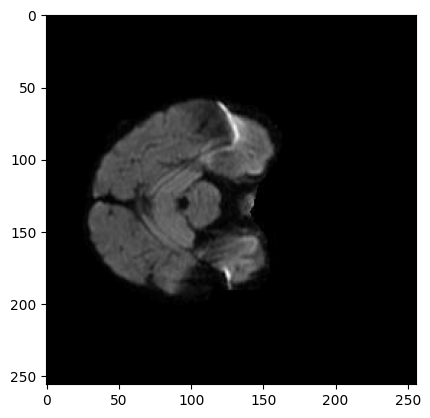

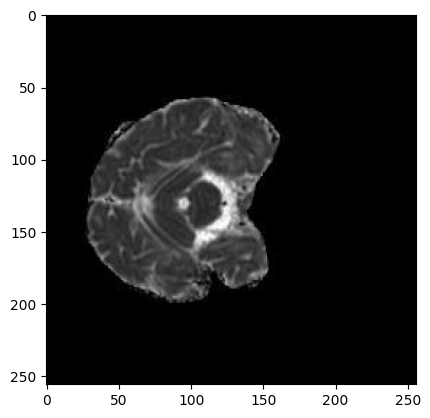

In [10]:
inp, re = load(str(PATH / 'train/train_000_10.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)
plt.show()

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}, you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [11]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [12]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [13]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [14]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [15]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

You can inspect some of the preprocessed output:

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [16]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [17]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Build an input pipeline with `tf.data`

In [18]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'), shuffle=False)
except tf.errors.InvalidArgumentError:
  print("GGARZON: 'tf.errors.InvalidArgumentError' test folder not found")
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'), shuffle=False)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [20]:
try:
  testmask_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'), shuffle=False)
except tf.errors.InvalidArgumentError:
  testmask_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'), shuffle=False)
testmask_dataset = testmask_dataset.map(load_image_test)
testmask_dataset = testmask_dataset.batch(BATCH_SIZE)

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597){:.external}. A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](../images/segmentation.ipynb) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}.)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [21]:
OUTPUT_CHANNELS = 3

In [22]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [23]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
#print (down_result.shape)

Define the upsampler (decoder):

In [24]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [25]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
#print (up_result.shape)

Define the generator with the downsampler and the upsampler:

In [26]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

In [27]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=32)

Test the generator:

In [28]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
# plt.imshow(gen_output[0, ...])
# plt.show()

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [29]:
LAMBDA = 100

In [30]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [32]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

In [33]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=32)

Test the discriminator:

In [34]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
#plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
#plt.colorbar()
#plt.show()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [35]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the optimizers and a checkpoint-saver


In [36]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [38]:
def generate_images(model, test_input, tar, ep):
  prediction = model(test_input, training=True)
  #plt.figure(figsize=(15, 15))
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  image = np.zeros((256,768))
  image[:,:256] = test_input[0][:,:,0]
  image[:,256:512] = tar[0][:,:,0]
  image[:,512:] = prediction[0][:,:,0]
  plt.imsave("results/iter_"+str(ep)+".jpg", image, cmap="gray")
#   for i in range(3):
#     plt.subplot(1, 3, i+1)
#     plt.title(title[i])
#     # Getting the pixel values in the [0, 1] range to plot.
#     plt.imshow(display_list[i] * 0.5 + 0.5)
#     plt.axis('off')
#   plt.show()
  #print(ep)

Test the function:

In [39]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target, ep=0)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
  return disc_loss, gen_l1_loss

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [ ]:
numsteps = 80000

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()
  l1_losses = []
  dl_losses = []
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target, step.numpy())
      print(f"Step: {step//1000}k")

    dl, l1 = train_step(input_image, target, step)
    dl_losses.append(dl.numpy())
    l1_losses.append(l1.numpy())

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % numsteps == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
  
  #np.save("dloss.npy", np.array(dl_losses))
  #np.save("l1loss.npy", np.array(l1_losses))

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

Finally, run the training loop:

In [ ]:
fit(train_dataset, test_dataset, steps=numsteps)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [150]:
%cd /home/gustavogarzon/code/pix2pix/
!ls {checkpoint_dir}
!pwd

/home/gustavogarzon/code/pix2pix
checkpoint  ckpt-1.data-00000-of-00001	ckpt-1.index
/home/gustavogarzon/code/pix2pix


In [151]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [116]:
def maskbox(fn):
    #imgpath = "data-old/customnoss/testmaskB/"+fn
    #image = mpimg.imread(imgpath)
    #print(fn.shape)
    if fn.shape[2]>2:
        fn = fn[:,:,0]
    image = fn
    h_start = 0
    h_end = 0
    v_start = 0
    v_end = 0
    #print(np.sum(image, axis=0))
    for kk,p in enumerate(np.sum(image, axis=0)):
        if(p!=0):
            h_start = kk
            #print(kk)
            break
    for p in range(255,0,-1):
        if(np.sum(image, axis=0)[p]!=0):
            h_end = p
            #print(p)
            break
    for kk,p in enumerate(np.sum(image, axis=1)):
        if(p!=0):
            v_start = kk
            #print(kk)
            break
    for p in range(255,0,-1):
        if(np.sum(image, axis=1)[p]!=0):
            v_end = p
            #print(p)
            break
    return h_start,h_end,v_start,v_end

In [117]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [161]:
%cd "/root/.keras/datasets/"

/root/.keras/datasets


train_048_10.jpg
-1.0 0.9843137
-1.0 0.9638393
train_048_11.jpg
-1.0 0.99215686
-1.0 0.9850013
train_048_12.jpg
-1.0 1.0
-1.0 0.97781056
train_048_13.jpg
-1.0 0.96862745
-1.0 0.98484075
train_048_14.jpg
-1.0 1.0
-1.0 0.9891134
train_048_15.jpg
-1.0 0.99215686
-1.0 0.99327415
train_048_16.jpg
-1.0 1.0
-1.0 0.99246967
train_048_17.jpg
-1.0 0.99215686
-1.0 0.99213594
train_048_18.jpg
-1.0 0.9607843
-1.0 0.9315939
train_048_19.jpg
-1.0 0.9843137
-1.0 0.9239821
train_048_20.jpg
-1.0 1.0
-1.0 0.9571264
train_048_21.jpg
-1.0 1.0
-1.0 0.9533679
train_048_8.jpg
-1.0 0.96862745
-1.0 0.92587465
train_048_9.jpg
-1.0 1.0
-1.0 0.852792
train_049_10.jpg
-1.0 0.96862745
-1.0 0.9981654
train_049_11.jpg
-1.0 0.9607843
-1.0 0.98222417
train_049_12.jpg
-1.0 1.0
-1.0 0.99354064
train_049_13.jpg
-1.0 1.0
-1.0 0.9856889
train_049_14.jpg
-1.0 1.0
-1.0 0.99328864
train_049_15.jpg
-1.0 1.0
-1.0 0.992145
-0.03198355969895298 6.917075948039519


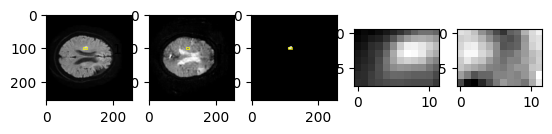

train_049_16.jpg
-1.0 0.99215686
-1.0 0.99366784
-0.18254309714150926 3.647076440096409


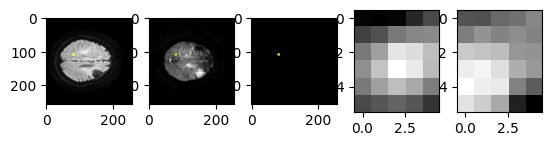

train_049_17.jpg
-1.0 0.9764706
-1.0 0.9958833
train_049_18.jpg
-1.0 1.0
-1.0 0.98499775
0.020396523251706225 4.23719080300766


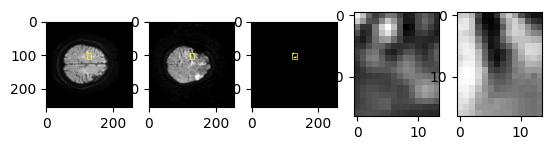

train_049_19.jpg
-1.0 0.99215686
-1.0 0.98066247
train_049_20.jpg
-1.0 1.0
-1.0 0.9701378
-0.1341643599793315 10.873074443179132


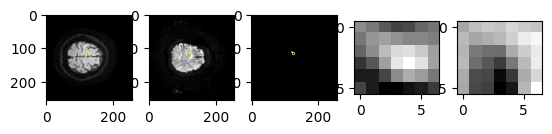

train_049_21.jpg
-1.0 1.0
-1.0 0.982208
train_049_9.jpg
-1.0 0.9764706
-1.0 0.9998288
train_050_10.jpg
-1.0 1.0
-1.0 0.9939066
0.1423814765689063 10.90003662842512


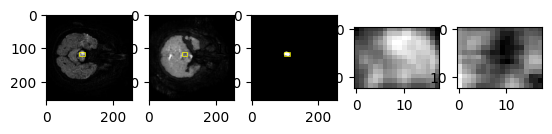

train_050_11.jpg
-1.0 1.0
-1.0 0.9219665
train_050_12.jpg
-1.0 0.94509804
-1.0 0.94169533
train_050_13.jpg
-1.0 0.9607843
-1.0 0.93962824
train_050_14.jpg
-1.0 1.0
-1.0 0.9848659
train_050_15.jpg
-1.0 0.96862745
-1.0 0.9891666
train_050_16.jpg
-1.0 0.96862745
-1.0 0.98372954
train_050_17.jpg
-1.0 0.9372549
-1.0 0.9882209
train_050_18.jpg
-1.0 1.0
-1.0 0.9836391
train_050_19.jpg
-1.0 0.9764706
-1.0 0.9792546
train_050_20.jpg
-1.0 0.92156863
-1.0 0.93436706
train_050_21.jpg
-1.0 0.99215686
-1.0 0.94809884
train_050_22.jpg
-1.0 0.94509804
-1.0 0.9891264
train_050_23.jpg
-1.0 1.0
-1.0 0.95493424
train_050_24.jpg
-1.0 1.0
-1.0 0.91807157
train_051_10.jpg
-1.0 1.0
-1.0 0.9502861
train_051_11.jpg
-1.0 0.9137255
-1.0 0.90650344
train_051_12.jpg
-1.0 0.92156863
-1.0 0.9624419
train_051_13.jpg
-1.0 1.0
-1.0 0.9845497
train_051_14.jpg
-1.0 0.8901961
-1.0 0.95790136
train_051_15.jpg
-1.0 0.96862745
-1.0 0.97274613
train_051_16.jpg
-1.0 0.9607843
-1.0 0.9885944
train_051_17.jpg
-1.0 1.0
-1.0 0.9831

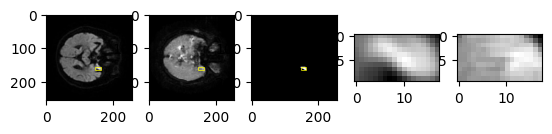

train_053_12.jpg
-1.0 0.99215686
-1.0 0.9478689
0.07140831869959928 13.440530670212373


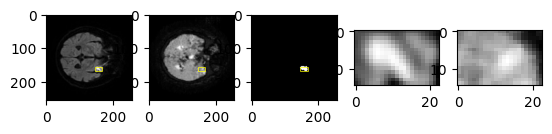

train_053_13.jpg
-1.0 1.0
-1.0 0.96549207
0.10688752926961377 11.24288298103288


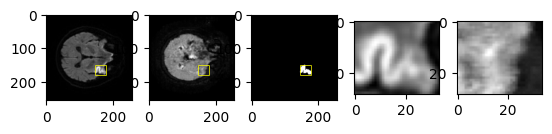

train_053_14.jpg
-1.0 0.9843137
-1.0 0.9788204
0.1019541074300733 12.072710042246728


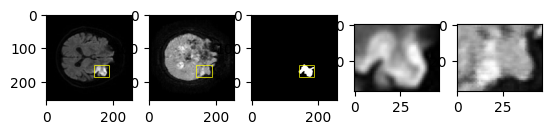

train_053_15.jpg
-1.0 1.0
-1.0 0.9599886
0.10001142639945383 13.172478810299202


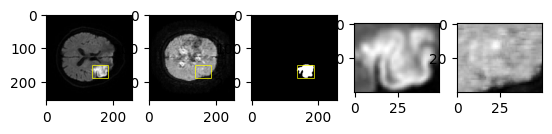

train_053_16.jpg
-1.0 0.9843137
-1.0 0.9643442
0.03606363456343399 12.945191506342606


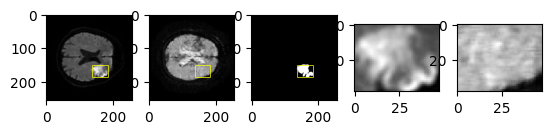

train_053_17.jpg
-1.0 0.9529412
-1.0 0.9874271
-0.010786633825083132 13.242558555098512


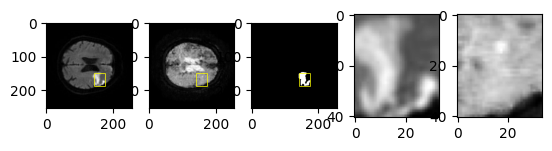

train_053_18.jpg
-1.0 0.9843137
-1.0 0.9985534
0.013298083031092438 12.626360361154479


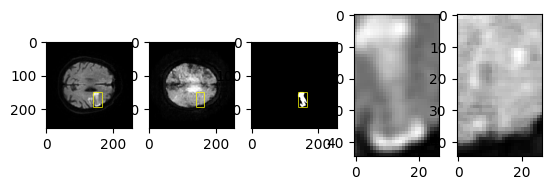

train_053_19.jpg
-1.0 0.9843137
-1.0 0.96112955
-0.059748345823566154 14.010042120992885


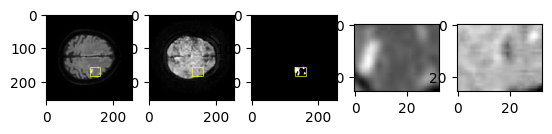

train_053_20.jpg
-1.0 1.0
-1.0 0.8556856
-0.10824133434410517 12.339170009945953


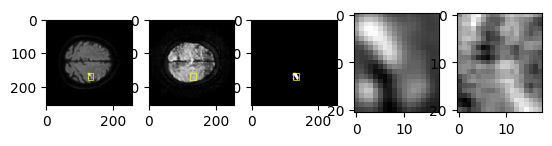

train_053_21.jpg
-1.0 1.0
-1.0 0.8828313
-0.06746535366945355 13.629256408584425


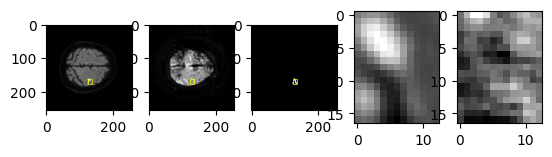

train_053_22.jpg
-1.0 0.96862745
-1.0 0.9440968
0.027321795680109062 16.198203063701474


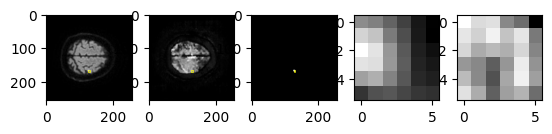

train_053_8.jpg
-1.0 1.0
-1.0 0.9088835
train_053_9.jpg
-1.0 0.99215686
-1.0 0.9297486
train_054_10.jpg
-1.0 1.0
-1.0 0.91480905
-0.013993437956756949 10.528848483946334


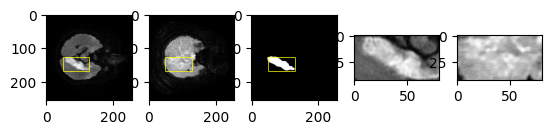

train_054_11.jpg
-1.0 1.0
-1.0 0.95010996
-0.11197959074113321 9.695178806152324


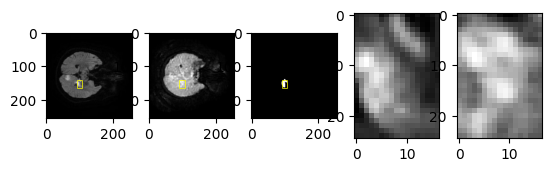

train_054_12.jpg
-1.0 0.9843137
-1.0 0.9699961
train_054_13.jpg
-1.0 0.9529412
-1.0 0.99322724
train_054_14.jpg
-1.0 0.9843137
-1.0 0.97761065
train_054_15.jpg
-1.0 1.0
-1.0 0.991759
train_054_16.jpg
-1.0 0.9529412
-1.0 0.9647877
train_054_17.jpg
-1.0 1.0
-1.0 0.94878227
train_054_18.jpg
-1.0 1.0
-1.0 0.89339
train_054_19.jpg
-1.0 0.99215686
-1.0 0.92721283
train_054_20.jpg
-1.0 1.0
-1.0 0.9711371
train_054_8.jpg
-1.0 0.9372549
-1.0 0.90963525
0.011224803347181707 13.945585014798656


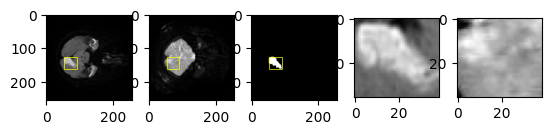

train_054_9.jpg
-1.0 1.0
-1.0 0.9142903
0.05287444424129422 12.851120976973842


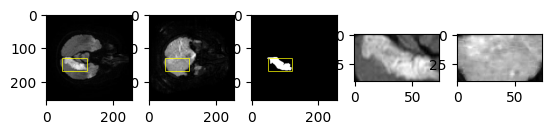

train_055_10.jpg
-1.0 0.9843137
-1.0 0.92394364
-0.07277876883745193 8.328640101167782


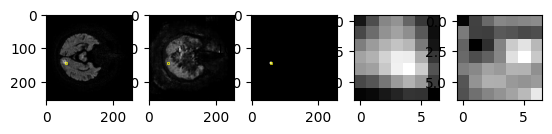

train_055_11.jpg
-1.0 1.0
-1.0 0.8851145
train_055_12.jpg
-1.0 1.0
-1.0 0.86967486
train_055_13.jpg
-1.0 0.9764706
-1.0 0.88058865
train_055_14.jpg
-1.0 0.92156863
-1.0 0.92124456
train_055_15.jpg
-1.0 0.9372549
-1.0 0.8414037
train_055_16.jpg
-1.0 0.94509804
-1.0 0.8925004
train_055_17.jpg
-1.0 0.9607843
-1.0 0.84345794
train_055_18.jpg
-1.0 1.0
-1.0 0.9265281
train_055_19.jpg
-1.0 1.0
-1.0 0.9475268
train_055_20.jpg
-1.0 0.9843137
-1.0 0.94112986
train_055_21.jpg
-1.0 1.0
-1.0 0.8533304
train_055_22.jpg
-1.0 1.0
-1.0 0.73547506
train_055_8.jpg
-1.0 1.0
-1.0 0.9321261
0.02498426614329219 6.378298867198557


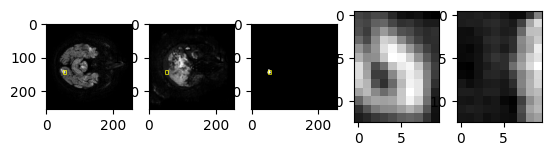

train_055_9.jpg
-1.0 1.0
-1.0 0.9276003
-0.05081032807273524 9.251643844916835


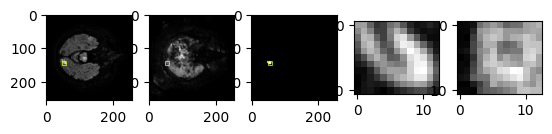

train_056_10.jpg
-1.0 1.0
-1.0 0.96238846
-0.4658292941749096 14.545103145495782


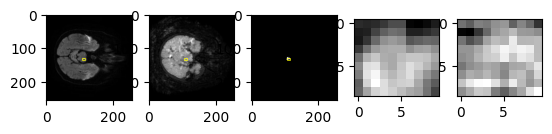

train_056_11.jpg
-1.0 0.99215686
-1.0 0.92776746
train_056_12.jpg
-1.0 1.0
-1.0 0.96742314
train_056_13.jpg
-1.0 1.0
-1.0 0.9298452
train_056_14.jpg
-1.0 1.0
-1.0 0.88253486
train_056_15.jpg
-1.0 1.0
-1.0 0.9355127
train_056_16.jpg
-1.0 1.0
-1.0 0.8733654
train_056_17.jpg
-1.0 1.0
-1.0 0.87810814
train_056_18.jpg
-1.0 0.99215686
-1.0 0.95185864
train_056_19.jpg
-1.0 1.0
-1.0 0.98065436
train_056_20.jpg
-1.0 1.0
-1.0 0.9799831
train_056_21.jpg
-1.0 1.0
-1.0 0.94535166
train_056_22.jpg
-1.0 1.0
-1.0 0.8703998
train_056_23.jpg
-1.0 0.96862745
-1.0 0.99797785
train_056_9.jpg
-1.0 1.0
-1.0 0.9538179
-0.057586764094334546 14.933685971055287


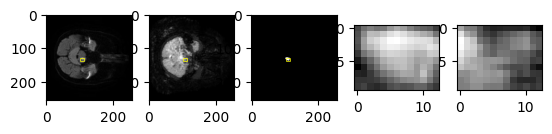

train_057_10.jpg
-1.0 0.9764706
-1.0 0.88821125
0.0937803641145567 14.063918133241662


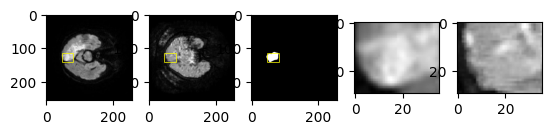

train_057_11.jpg
-1.0 1.0
-1.0 0.83987623
0.11044550161327556 12.27745878666303


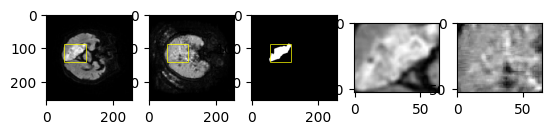

train_057_12.jpg
-1.0 0.99215686
-1.0 0.94853497
0.019261090216430916 10.402815549106982


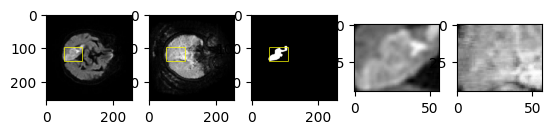

train_057_13.jpg
-1.0 1.0
-1.0 0.8749129
0.034094888623256984 14.119056291899383


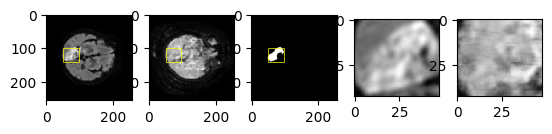

train_057_14.jpg
-1.0 1.0
-1.0 0.92750424
0.04630940729898325 15.998115206089498


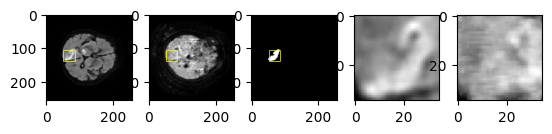

train_057_15.jpg
-1.0 1.0
-1.0 0.9155047
0.11410762148263748 15.287209179247442


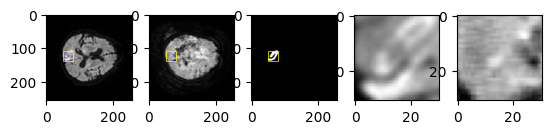

train_057_16.jpg
-1.0 1.0
-1.0 0.89250624
-0.11728063381876079 11.506352768146492


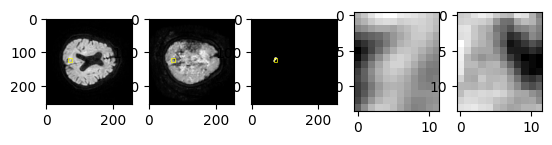

train_057_17.jpg
-1.0 0.9764706
-1.0 0.96939176
train_057_18.jpg
-1.0 1.0
-1.0 0.98099387
train_057_19.jpg
-1.0 0.99215686
-1.0 0.9525494
train_057_20.jpg
-1.0 1.0
-1.0 0.9386984
train_057_21.jpg
-1.0 1.0
-1.0 0.9560953
train_057_22.jpg
-1.0 1.0
-1.0 0.87151027
train_057_9.jpg
-1.0 0.9764706
-1.0 0.9579419
0.02408162389120439 13.321336318380826


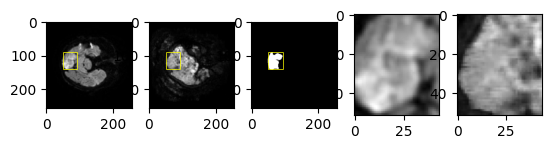

train_058_10.jpg
-1.0 1.0
-1.0 0.9422831
train_058_11.jpg
-1.0 1.0
-1.0 0.97378397
train_058_12.jpg
-1.0 0.96862745
-1.0 0.92159057
train_058_13.jpg
-1.0 0.99215686
-1.0 0.88902265
train_058_14.jpg
-1.0 0.9843137
-1.0 0.9359267
train_058_15.jpg
-1.0 1.0
-1.0 0.9622733
train_058_16.jpg
-1.0 0.99215686
-1.0 0.9525708
train_058_17.jpg
-1.0 0.99215686
-1.0 0.9394159
train_058_18.jpg
-1.0 1.0
-1.0 0.9348771
train_058_19.jpg
-1.0 0.9607843
-1.0 0.93446004
train_058_20.jpg
-1.0 0.99215686
-1.0 0.95262766
train_058_21.jpg
-1.0 0.9843137
-1.0 0.97744995
train_058_8.jpg
-1.0 0.9764706
-1.0 0.66067946
train_058_9.jpg
-1.0 1.0
-1.0 0.92172164
train_059_10.jpg
-1.0 1.0
-1.0 0.9215851
train_059_11.jpg
-1.0 1.0
-1.0 0.9462764
train_059_12.jpg
-1.0 1.0
-1.0 0.9162369
train_059_13.jpg
-1.0 0.9764706
-1.0 0.9079443
train_059_14.jpg
-1.0 1.0
-1.0 0.9526136
train_059_15.jpg
-1.0 1.0
-1.0 0.96222615
train_059_16.jpg
-1.0 1.0
-1.0 0.9705806
train_059_17.jpg
-1.0 0.9529412
-1.0 0.9837724
train_059_18.jpg
-1.

In [162]:
pathmask = "/home/gustavogarzon/code/cyclegan/cyclegan_tf/data/foscal/maskA/"
mylistmask = os.listdir(pathmask)
mylistmask.sort()
#print(mylistmask)
#print(len(mylistmask))

#mylisttest = os.listdir("adc2dwi/test/")
#mylisttest = os.listdir("dwi2adc/test/")
#mylisttest = os.listdir("dwi2ncct/test/")
#mylisttest = os.listdir("adc2dwi-noss/test/")
#mylisttest = os.listdir("dwi2adc-noss/test/")
mylisttest = os.listdir("dwi2ncct-noss/test/")
mylisttest.sort()
#print(mylisttest)
#print(len(mylisttest))

#pathimgs = "adc2dwi/test/"

all_s1m = []
all_s2m = []

for i in mylisttest:
    pathnew = str(PATH)+"/test/"+i
    print(i)
    pts = i.split("_")
    inp, re = normalize(*load(pathnew))
    inp = inp[np.newaxis,:,:,:]
    prediction = generator(inp, training=True)[0]
    re = np.array(re)
    prediction = np.array(prediction)
    fmask = pts[0]+"_"+pts[1]+"_mask_"+pts[2].replace("jpg","png")
    print(np.min(re), np.max(re))
    print(np.min(prediction), np.max(prediction))
    if os.path.isfile(pathmask+fmask):
        imagemask = mpimg.imread(pathmask+fmask)
        h_start,h_end,v_start,v_end = maskbox(imagemask)
        if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
            ws = None
            if re[h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or prediction[h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
                ws = 3
            s1m = ssim(re[v_start:v_end+1,h_start:h_end+1,0], prediction[v_start:v_end+1,h_start:h_end+1,0], win_size=ws)
            s2m = psnr(re[v_start:v_end+1,h_start:h_end+1,0], prediction[v_start:v_end+1,h_start:h_end+1,0])
            all_s1m.append(s1m)
            all_s2m.append(s2m)
            print(s1m, s2m)
            #plt.subplot(1,4,1)
            #plt.imshow(inp[0,:,:,0], cmap="gray")
            plt.subplot(1,5,1)
            plt.imshow(re[:,:,0], cmap="gray")
            plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.subplot(1,5,2)
            plt.imshow(prediction[:,:,0], cmap="gray")
            plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.subplot(1,5,3)
            plt.imshow(imagemask[:,:,0], cmap="gray")
            plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=0.5)
            plt.subplot(1,5,4)
            plt.imshow(re[v_start:v_end+1,h_start:h_end+1,0], cmap="gray")
            plt.subplot(1,5,5)
            plt.imshow(prediction[v_start:v_end+1,h_start:h_end+1,0], cmap="gray")
            plt.show()
        #break
    else:
        print("MASK error in: ",i)

In [163]:
avg_s1m = np.mean(all_s1m)
avg_s2m = np.mean(all_s2m)

print("-------------------------------------------------")
print("MASK")
print("SSIM: "+str(avg_s1m), "  ", "PSNR: "+str(avg_s2m))

-------------------------------------------------
MASK
SSIM: -0.005372820282026456    PSNR: 11.857300691901258


<br><br><br><br>

(1, 256, 256, 3)
-1.0 0.9843137
-1.0 1.0
-1.0 0.98341525
SSIM: 0.8749295272974756    PSNR: 18.7095815036276   


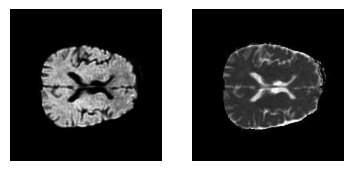

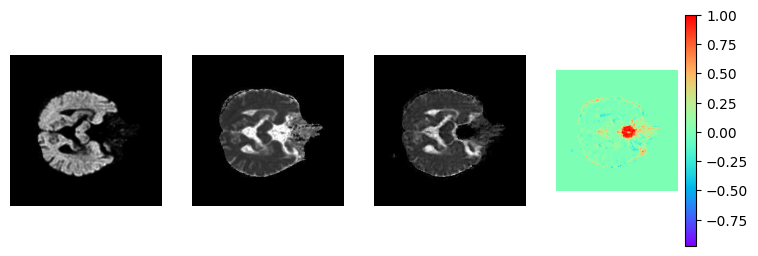

(1, 256, 256, 3)
-1.0 0.99215686
-1.0 1.0
-1.0 0.98971945
SSIM: 0.8853895886044919    PSNR: 22.50966250781264   


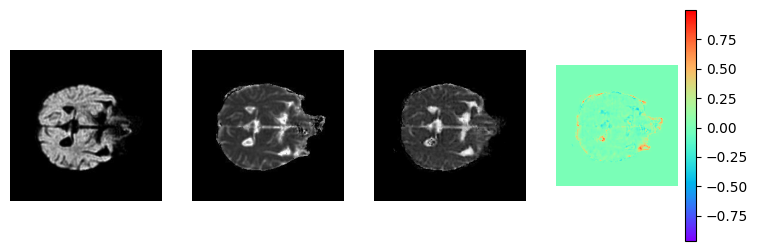

(1, 256, 256, 3)
-1.0 1.0
-1.0 1.0
-1.0 0.9916449
SSIM: 0.8939207780159479    PSNR: 23.178886781476788   


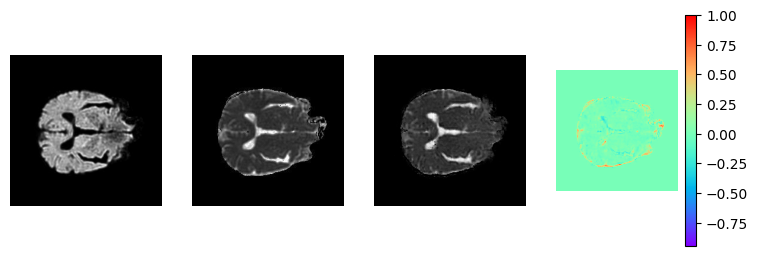

(1, 256, 256, 3)
-1.0 0.96862745
-1.0 1.0
-1.0 0.94665134
SSIM: 0.9024489512446241    PSNR: 22.658472962011228   


KeyboardInterrupt: 

In [49]:
all_s1 = []
all_s2 = []
all_s3 = []

ncct_list = []

for inp, tar in test_dataset.take(184):
    print(inp.shape)
    #print(inp.numpy()[0].shape)
    print(np.min(inp), np.max(inp))
    print(np.min(tar), np.max(tar))
    ncct_list.append(inp.numpy()[0])
    prediction = generator(inp.numpy(), training=True)[0]
    print(np.min(prediction), np.max(prediction))
    pred = (prediction[:,:,0]*0.5+0.5).numpy()
    target = (tar[0][:,:,0]*0.5+0.5).numpy()
    myinput = (inp[0][:,:,0]*0.5+0.5).numpy()
    s1 = ssim(target, pred)
    s2 = psnr(target, pred)
    #s3 = np.abs(np.sum(target-pred))
    
    #h_start,h_end,v_start,v_end = maskbox(fn)
    
    #print("SSIM: "+str(s1), "  ", "PSNR: "+str(s2), "  ", "L1: "+str(s3))
    print("SSIM: "+str(s1), "  ", "PSNR: "+str(s2), "  ")
    all_s1.append(s1)
    all_s2.append(s2)
    #all_s3.append(s3)
    plt.figure(figsize=(9,3))
    plt.subplot(1,4,1)
    plt.imshow(myinput, cmap="gray")
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(target, cmap="gray")
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(pred, cmap="gray")
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(target-pred, cmap="rainbow")
    plt.axis('off')
    plt.colorbar()
    plt.savefig("test.png", bbox_inches='tight')
    plt.show()
    #break

avg_s1 = np.mean(all_s1)
avg_s2 = np.mean(all_s2)
#avg_s3 = np.mean(all_s3)
print("\n")
#print("SSIM: "+str(avg_s1), "  ", "PSNR: "+str(avg_s2), "  ", "L1: "+str(avg_s3))
print("-------------------------------------------------")
print("AVG")
print("SSIM: "+str(avg_s1), "  ", "PSNR: "+str(avg_s2))

<br><br><br><br>

## GENERAR IMGS

In [ ]:
#from helper_funcs3 import *
def load_data(subfolder='', generator=False):
    def create_image_array(image_list, image_path, image_size, nr_of_channels, mask=False):
        #bar = Bar('Loading...', max=len(image_list))

        # Define image array
        image_array = np.empty((len(image_list),) + (image_size) + (nr_of_channels,))
        i = 0
        for image_name in image_list:
            # If file is image...
            if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
                # Load image and convert into np.array
                image = mpimg.imread(os.path.join(image_path, image_name))  # Normalized to [0,1]
                # image = np.array(Image.open(os.path.join(image_path, image_name)))

                # Add third dimension if image is 2D
                # GGARZON: sgtes dos lineas como comentarios
                #if nr_of_channels == 1:  # Gray scale image -> MR image
                #    image = image[:, :, np.newaxis]

                # Normalize image with (max 8 bit value - 1)
                if not mask:
                    #image = image * 2 - 1
                    image = image / 127.5 - 1
                else:
                    image[image==1] = 0.9
                # image = image / 127.5 - 1

                # Add image to array
                #image_array[i, :, :, :] = image
                #image_array[i, :, :, :] = image[:,:,0:1] #v2
                
                #v1
                if(len(image.shape)>2):
                    #print(len(image.shape))
                    #print("GGARZON", image.shape)
                    image_array[i, :, :, :] = image[:, :, 0, np.newaxis]
                else:
                    image_array[i, :, :, :] = image[:, :, np.newaxis]
                i += 1
                #bar.next()
        #bar.finish()

        return image_array

    # Image paths
    imgA_path = os.path.join(subfolder, 'train')
    imgB_path = os.path.join(subfolder, 'test')
    #trainB_path = os.path.join('data', subfolder, 'trainB')
    #maskA_path = os.path.join('data', subfolder, 'maskA')
    #maskB_path = os.path.join('data', subfolder, 'maskB')
    #testB_path = os.path.join('data', subfolder, 'testB')
    
    # Image file names
    imgA_image_names = sorted(os.listdir(imgA_path))
    imgB_image_names = sorted(os.listdir(imgB_path))
    #trainB_image_names = sorted(os.listdir(trainB_path))
    #maskA_image_names = sorted(os.listdir(maskA_path))
    #maskB_image_names = sorted(os.listdir(maskB_path))
    #testB_image_names = sorted(os.listdir(testB_path))

    # Examine one image to get size and number of channels
    im_test = mpimg.imread(os.path.join(imgA_path, imgA_image_names[0]))
    # im_test = np.array(Image.open(os.path.join(trainA_path, trainA_image_names[0])))

    if len(im_test.shape) == 2:
        image_size = im_test.shape
        nr_of_channels = 1
    else:
        image_size = im_test.shape[0:-1]
        #nr_of_channels = im_test.shape[-1]
        nr_of_channels = 1 #GGARZON

    imgA_images = create_image_array(imgA_image_names, imgA_path, image_size, nr_of_channels)
    imgB_images = create_image_array(imgB_image_names, imgB_path, image_size, nr_of_channels)
    #trainB_images = create_image_array(trainB_image_names, trainB_path, image_size, nr_of_channels)
    #maskA_images = create_image_array(maskA_image_names, maskA_path, image_size, nr_of_channels, mask=True)
    #maskB_images = create_image_array(maskB_image_names, maskB_path, image_size, nr_of_channels, mask=True)
    #testB_images = create_image_array(testB_image_names, testB_path, image_size, nr_of_channels)
    
    return {"imgA_images": imgA_images,
            "imgB_images": imgB_images,
            "imgA_image_names": imgA_image_names,
            "imgB_image_names": imgB_image_names,}

In [ ]:
image_folder = 'ncct2adc'
data = load_data(subfolder=image_folder)

In [ ]:
opt = {}

X_train = data["imgA_images"]
X_test = data["imgB_images"]

print(data["imgA_image_names"][0])
print(data["imgB_image_names"][0])

print(X_train.shape)
print(X_test.shape)

In [ ]:
print(data["imgA_image_names"][0])
plt.imshow(X_train[0], cmap="gray")
plt.show()

In [ ]:
#k = 1
#for inp, tar in train_dataset.take(708):
for k in range(X_train.shape[0]):
    #print(img)
    #print(inp.numpy()[0].shape)
    #ncct_list.append(inp.numpy()[0])
    #print(tar.numpy().shape)
    #print(type(tar.numpy()))
    print(data["imgA_image_names"][k])
    img = np.repeat(X_train[k][np.newaxis,:,:256,:], 3, axis=3)
    prediction = generator(img, training=True)[0]
    
    #plt.subplot(1,2,1)
    #plt.imshow(X_train[k][:,:256,0], cmap="gray")
    #plt.subplot(1,2,2)
    #plt.imshow(prediction[:,:,0]*0.5+0.5, cmap="gray")
    #     plt.imsave("inference/"+data["imgA_image_names"][k], prediction[:,:,0]*0.5+0.5, cmap="gray")
    plt.imsave("inference/ncct/"+data["imgA_image_names"][k], X_train[k][:,:256,0], cmap="gray")
    #plt.show()
    k += 1
    #break

In [ ]:
#k = 1
#for inp, tar in train_dataset.take(708):
for k in range(X_test.shape[0]):
    #print(img)
    #print(inp.numpy()[0].shape)
    #ncct_list.append(inp.numpy()[0])
    #print(tar.numpy().shape)
    #print(type(tar.numpy()))
    print(data["imgB_image_names"][k])
    img = np.repeat(X_test[k][np.newaxis,:,:256,:], 3, axis=3)
    prediction = generator(img, training=True)[0]
    
    #plt.subplot(1,2,1)
    #plt.imshow(X_test[k][:,:256,0], cmap="gray")
    #plt.subplot(1,2,2)
    #plt.imshow(prediction[:,:,0]*0.5+0.5, cmap="gray")
    plt.imsave("inference/test/"+data["imgB_image_names"][k], prediction[:,:,0]*0.5+0.5, cmap="gray")
    #plt.imsave("inference/ncct/"+data["imgB_image_names"][k], X_test[k][:,:256,0], cmap="gray")
    #plt.show()
    k += 1
    #break

In [ ]:
image = mpimg.imread("ncct2adc/test/train_059_9.jpg")
plt.imshow(image, cmap="gray")
plt.show()

<br><br><br><br>

In [ ]:
len(ncct_list)

In [ ]:
all_s1 = []
all_s2 = []
all_s3 = []
all_s4 = []

total = 0
k = 0

plt.figure(figsize=(15,5))

for inp, tar in testmask_dataset.take(184):
    myinput = inp[0][:,:,0]*0.5+0.5
    target = (tar[0][:,:,0]*0.5+0.5).numpy()
    suma = np.sum(myinput)
    all_s1.append(0)
    all_s2.append(0)
    #print("target.shape: ", target.shape)
    if suma>2:
        total += 1
        #print(np.min(myinput), np.max(myinput), suma)
        #print(inp[0][:,:,0].shape)
        #print(np.min(inp[0][:,:,0]), np.max(inp[0][:,:,0]))
        #print(np.sum(inp[0][:,:,0]+1, axis=0))
        h_start,h_end,v_start,v_end = maskbox(inp[0][:,:,0]+1)
        print(h_start,h_end,v_start,v_end)
        pred = generator(ncct_list[k][np.newaxis,:,:,:], training=True)[0].numpy()
        #plt.figure(figsize=(9,3))
        plt.subplot(1,6,1)
        plt.imshow(target, cmap="gray")
        plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid")
        plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid")
        plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid")
        plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid")
        plt.axis('off')
        plt.subplot(1,6,2)
        plt.imshow(myinput, cmap="gray")
        plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid")
        plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid")
        plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid")
        plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid")
        plt.axis('off')
        plt.subplot(1,6,3)
        plt.imshow(pred[:,:,0], cmap="gray")
        plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid")
        plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid")
        plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid")
        plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid")
        plt.axis('off')
#         plt.subplot(1,4,4)
#         plt.imshow(ncct_list[k][:,:,0], cmap="gray")
        ws = None
        if target[h_start:h_end+1,v_start:v_end+1].shape[0]<7 or target[h_start:h_end+1,v_start:v_end+1].shape[1]<7:
            print("WS modificado!")
            ws = 3
        s3 = ssim(target[v_start:v_end+1,h_start:h_end+1], pred[v_start:v_end+1,h_start:h_end+1,0], win_size=ws)
        s4 = psnr(target[v_start:v_end+1,h_start:h_end+1], pred[v_start:v_end+1,h_start:h_end+1,0])
        all_s3.append(s3)
        all_s4.append(s4)
        plt.subplot(1,6,4)
        plt.imshow(target[v_start:v_end+1,h_start:h_end+1], cmap="gray")
        plt.axis('off')
        plt.subplot(1,6,5)
        plt.imshow(pred[v_start:v_end+1,h_start:h_end+1,0], cmap="gray")
        plt.axis('off')
        plt.subplot(1,6,6)
        plt.imshow(myinput[v_start:v_end+1,h_start:h_end+1], cmap="gray")
        plt.axis('off')
        plt.show()
        outputfile = "inference/"
        plt.savefig("test.png", bbox_inches='tight')
        print(s3, s4)
        s3 = ssim(target[h_start:h_end+1,v_start:v_end+1], pred[h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
        s4 = psnr(target[h_start:h_end+1,v_start:v_end+1], pred[h_start:h_end+1,v_start:v_end+1,0])
        print(s3, s4)
        #break
#     else:
#         print("file", np.min(myinput), np.max(myinput), suma)
#         #plt.figure(figsize=(9,3))
#         plt.subplot(1,3,1)
#         plt.imshow(target, cmap="gray")
#         plt.subplot(1,3,2)
#         plt.imshow(myinput, cmap="gray")
    #plt.show()
    k = k+1
    #break

print("total:", total)

avg_s1 = np.mean(all_s1)
avg_s2 = np.mean(all_s2)
avg_s3 = np.mean(all_s3)
avg_s4 = np.mean(all_s4)

In [ ]:
print("ADC reconstruction")
print("ssim","\t\tpsnr","\t\tssim-mask","\t\tpsnr-mask")
avg_s1, avg_s2, avg_s3, avg_s4

In [ ]:
np.min(all_s3), np.max(all_s3)

In [ ]:
np.min(all_s4), np.max(all_s4)